<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">


---
<h3>Jon Amelibia, Iker Cumplido, Aitor Hernandez, Daniel Puente and Iñigo Ugarte

## Index
---

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>

### <a id='1'>1. Loading of Libraries and Data</a>
---

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from itertools import chain

import warnings
warnings.filterwarnings('ignore')

Necessary functions to evaluate the model

In [2]:
def x_and_y(df_desc_final_pickle, num_steps = 10, index = False):
    x, y, quantiles_final, new_values = [], [], [], []
    for i in range(1, 9):
        if index:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.cell == i]
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):
                x.append(np.array(batery_df.iloc[slice(j,num_steps+j), 1:].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.iloc[slice(j,num_steps+j), 1:].RUL.values[-1], i]))
                quantiles.append(i)
        else:
            batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
            batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
            quantiles = []
            for j in range(1, len(batery_df) - num_steps):

                x.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].drop(columns=['RUL']).values))
                y.append(np.array([batery_df.loc[(1, slice(j,num_steps+j)), :].RUL.values[-1], i]))
                quantiles.append(i)

        quantiles_final.append(np.array_split(range(len(quantiles)), 4))
            
    x, y = np.array(x), np.array(y)

    for j in np.unique(y[:,1]):
        batery_column = y[:,1][y[:,1] == j]
        new_values.append([i+1 for i in range(4) for x in batery_column[quantiles_final[int(j-1)][i]].tolist()])
    y = np.append(y, np.array(list(chain(*new_values))).reshape(-1,1), axis = 1)
    y[:,0] = y[:,0].astype(float)
    print(x.shape, y.shape)
    return x, y

def customLoss(true,pred):
    diff = pred - true
    greater = K.greater(diff,0)
    greater = K.cast(greater, K.floatx()) 
    greater = greater + 1                
    return K.mean(K.square(diff))*greater

def customLoss_numpy(true,pred):
    diff = pred - true
    greater = np.max(diff)
    greater = greater + 1     
    return np.mean(greater*(diff**2))



Plotting functions

In [91]:
def scatter_cycle_plot(df_desc_final_pickle_load, battery, ypred, y_test, y_test_mod, index = False):

    differences = (y_test - ypred).flatten()
    list_soh = []
    for k, v in enumerate(differences):
        if y_test_mod[:,1][k] == battery:
            df_modify = df_desc_final_pickle_load.loc[y_test_mod[:,1][k],:]
            yellow = df_modify.head(1).RUL[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(0)[0]
            red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
            list_soh.append(v)

    plt.scatter(range(len(list_soh)), np.sort(list_soh), s = 110, color='k')
    plt.xticks(fontsize=22), plt.yticks(fontsize=22);
    plt.grid(linestyle='--',linewidth=1.5, alpha = 0.4);
    plt.xlabel('Instances', fontsize=24), plt.ylabel('Cycle error', fontsize=24), plt.title(f'Prediction cell {battery}', fontsize=24, fontweight='bold');

    yellow_lim = np.max(list_soh) + 50 if np.max(list_soh) > yellow else 100
    red_lim = np.min(list_soh) - 100 if np.min(list_soh) < 50 else 100
    annotation = abs((yellow + yellow_lim) - (red+red_lim)) / 40

    plt.axhspan(red, red+red_lim, facecolor='#f50400', alpha=0.3), plt.axhspan(yellow + yellow_lim, yellow, facecolor='#f4b41a', alpha=0.4), \
                                                                   plt.axhspan(yellow, 0, facecolor='#68da3e', alpha=0.4), plt.axhspan(0, red, facecolor='#f4b41a', alpha=0.4);
    for k,v in enumerate(np.sort(list_soh)): 
        if int(np.round(v)) < 0: plt.annotate( str(int(np.round(v))), (k, v + annotation), fontsize=18, color = 'r', fontweight='bold', rotation=90)
        else: plt.annotate( str(int(np.round(v))), (k, v + annotation), fontsize=18, color = 'k', fontweight='bold',rotation=90);
    plt.ylim(red+red_lim, yellow + yellow_lim);

def scatter_plot_prediction(ypred, y_test, y_test_mod):
    fig = plt.figure(figsize=(50, 20))
    for x in range(1, 9):
        plt.subplot(2, 4, x)
        scatter_cycle_plot(df_desc_final_pickle_load, x, ypred, y_test, y_test_mod, False)

def line_plot_result(ypred, y_test, title):
    ypred_ordered = ypred[np.argsort(y_test, axis=0)]
    y_test_ordered = np.sort(y_test, axis=0)

    plt.plot(y_test_ordered,  label='Real', color='#E76F51', linewidth=3);
    plt.plot(ypred_ordered.reshape(-1,1), 'bo',label='Prediction', color='#264653', linewidth=1);
    plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5, alpha = 0.5);
    plt.xlabel('Instances', fontsize=16), plt.ylabel('Cycles', fontsize=16), plt.title('Model results' + title, fontsize=16);
    plt.legend(fontsize=16);

def bar_plot_comparison(nombres, list_red, list_yellow, list_green):
    X_axis = np.arange(len(nombres))
    fig1, ax1 = plt.subplots(figsize = (27, 8))
    plt.bar(X_axis - 0.2, list_red, 0.2, color = '#f50400', label = 'SoH < 70', alpha = 0.3)
    plt.bar(X_axis, list_yellow, 0.2, color = '#f4b41a', label = 'SoH between [70, 80] or SoH > 81 ', alpha = 0.3)
    plt.bar(X_axis + 0.2, list_green, 0.2, color = '#68da3e', label = 'SoH between [80, 81]', alpha = 0.3)
    plt.xticks(X_axis, nombres, fontsize = 15), plt.yticks(fontsize = 15);
    plt.xlabel("Models", color = 'k', weight = 'bold', fontsize=15), plt.ylabel("Number of batteries", color = 'k', weight = 'bold', fontsize=15)
    plt.title("Model results by steps", color = 'k', weight = 'bold', fontsize=18)
    plt.legend(loc='upper left', fontsize=20, bbox_to_anchor=(1.01,1), borderaxespad=0)
    for p in ax1.patches: plt.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=14, weight = 'bold')

def green_yellow_red(ypred, y_test, y_test_mod):
    differences = (y_test - ypred).flatten()
    red_list, yellow_list, green_list = [], [], []
    for k, v in enumerate(differences):
        df_modify = df_desc_final_pickle_load[df_desc_final_pickle_load.index.get_level_values(0) == y_test_mod[k][1]]
        yellow = df_modify.head(1).RUL.values[0] - df_modify[df_modify['SoH_max_ch']>=81].tail(1).index.get_level_values(1)[0]
        red = df_modify.RUL.min() if len(df_modify[df_modify['SoH_max_ch']<70].head(1)) == 0 else df_modify[df_modify['SoH_max_ch']<70].head(1).RUL.values[0]
        if (v <= yellow) & (v >= 0): green_list.append(k)
        if (v <= red): red_list.append(k)
        if ((v > red) & (v < 0)) | (v > yellow) : yellow_list.append(k)
        
    return len(green_list), len(yellow_list), len(red_list)


Main variables

In [4]:
path_origin, path_processed = "../data/original_data/", "../data/processed_data/"
models_path = "../data/processed_data/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

Processed dataset      
We process the data, changing the type to float and removing the negatives

In [5]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
df_desc_final_pickle_not_index = df_desc_final_pickle.reset_index(col_level=0)
print(df_desc_final_pickle.shape)

(390, 41)


### Creating x and y
---

In [42]:
x, y = x_and_y(df_desc_final_pickle, num_steps = 10, index = False)
def stratified_split(x, y, stratify_2 = True):

    if stratify_2: X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,[1,2]])
    else: X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,[1]])

    y_train, y_test = y_train_mod[:,0].reshape(-1,1), y_test_mod[:,0].reshape(-1,1)

    X_train = np.stack(X_train, axis = 0)
    y_train = np.stack(y_train, axis = 0)

    X_test = np.stack(X_test, axis = 0)
    y_test = np.stack(y_test, axis = 0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    return X_train, X_test, y_train, y_test, y_train_mod, y_test_mod

X_train, X_test, y_train, y_test, y_train_mod, y_test_mod = stratified_split(x, y, stratify_2 = True)
X_train_false, X_test_false, y_train_false, y_test_false, y_train_mod_false, y_test_mod_false = stratified_split(x, y, stratify_2 = False)

(302, 11, 40) (302, 3)


### Results
---

First, we load the models

In [7]:
def return_metric(model_name, X_train, X_test, y_train, y_test, y_train_mod, y_test_mod):
    model = keras.models.load_model(models_path + f'{model_name}.h5', custom_objects={'customLoss': customLoss})
    ypred_train = model.predict(X_train)
    print('Train -->', r2_score(y_train, ypred_train), mean_absolute_error(y_train, ypred_train), np.sqrt(mean_squared_error(y_train, ypred_train)), customLoss_numpy(ypred_train, y_train))
    ypred = model.predict(X_test)
    print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), customLoss_numpy(ypred, y_test))
    print('')
    return ypred_train, ypred

We see the performance of each model

In [8]:
ypred_train_lstm_good_adapted, ypred_lstm_good_adapted = return_metric('first_model_LSTM', X_train, X_test, y_train, y_test, y_train_mod, y_test_mod)
ypred_train_gru_good_adapted, ypred_gru_good_adapted = return_metric('first_model_GRU', X_train, X_test, y_train, y_test, y_train_mod, y_test_mod)
ypred_train_bi_lstm_good_adapted_11, ypred_bi_lstm_good_adapted_11 = return_metric('first_model_Bidirectional_LSTM_good_adapted', X_train, X_test, y_train, y_test, y_train_mod, y_test_mod)
ypred_train_bi_gru_good_adapted, ypred_bi_lstm_gru_adapted = return_metric('first_model_Bidirectional_GRU', X_train, X_test, y_train, y_test, y_train_mod, y_test_mod)
ypred_train_bi_hyperas_lstm25, ypred_bi_hyperas_lstm25 = return_metric('tryals_bidirectional_lstm_25', X_train_false, X_test_false, y_train_false, y_test_false, y_train_mod_false, y_test_mod_false)
ypred_train_bi_hyperas_lstm24, ypred_bi_hyperas_lstm24 = return_metric('tryals_bidirectional_lstm_24', X_train_false, X_test_false, y_train_false, y_test_false, y_train_mod_false, y_test_mod_false)

8/8 [==============================] - 1s 4ms/step
Train --> -0.15824186623086978 979.6215968468377 1436.681860394769 9103551852.09952
2/2 [==============================] - 0s 5ms/step
Test --> -0.31622676752748324 1111.9893808833888 1571.735836849322 11142575482.580719

8/8 [==============================] - 1s 38ms/step
Train --> 0.9966980610878523 41.99316976080297 76.70885424603892 3138806.8838582076
2/2 [==============================] - 0s 52ms/step
Test --> 0.9855367419474046 115.00336468806032 164.75828539841666 15012738.538334267

8/8 [==============================] - 1s 52ms/step
Train --> 0.9986223938717107 36.26409035203862 49.547701427739874 400800.9943118187
2/2 [==============================] - 0s 53ms/step
Test --> 0.9937188394985599 76.92724434274142 108.57607594566089 4745582.0221905885

8/8 [==============================] - 1s 5ms/step
Train --> 0.9988491492088808 21.939030026004524 45.286680599566665 748463.3020360948
2/2 [==============================] - 0s 11

### Plotting results
---

#### **Final LSTM**

* Test

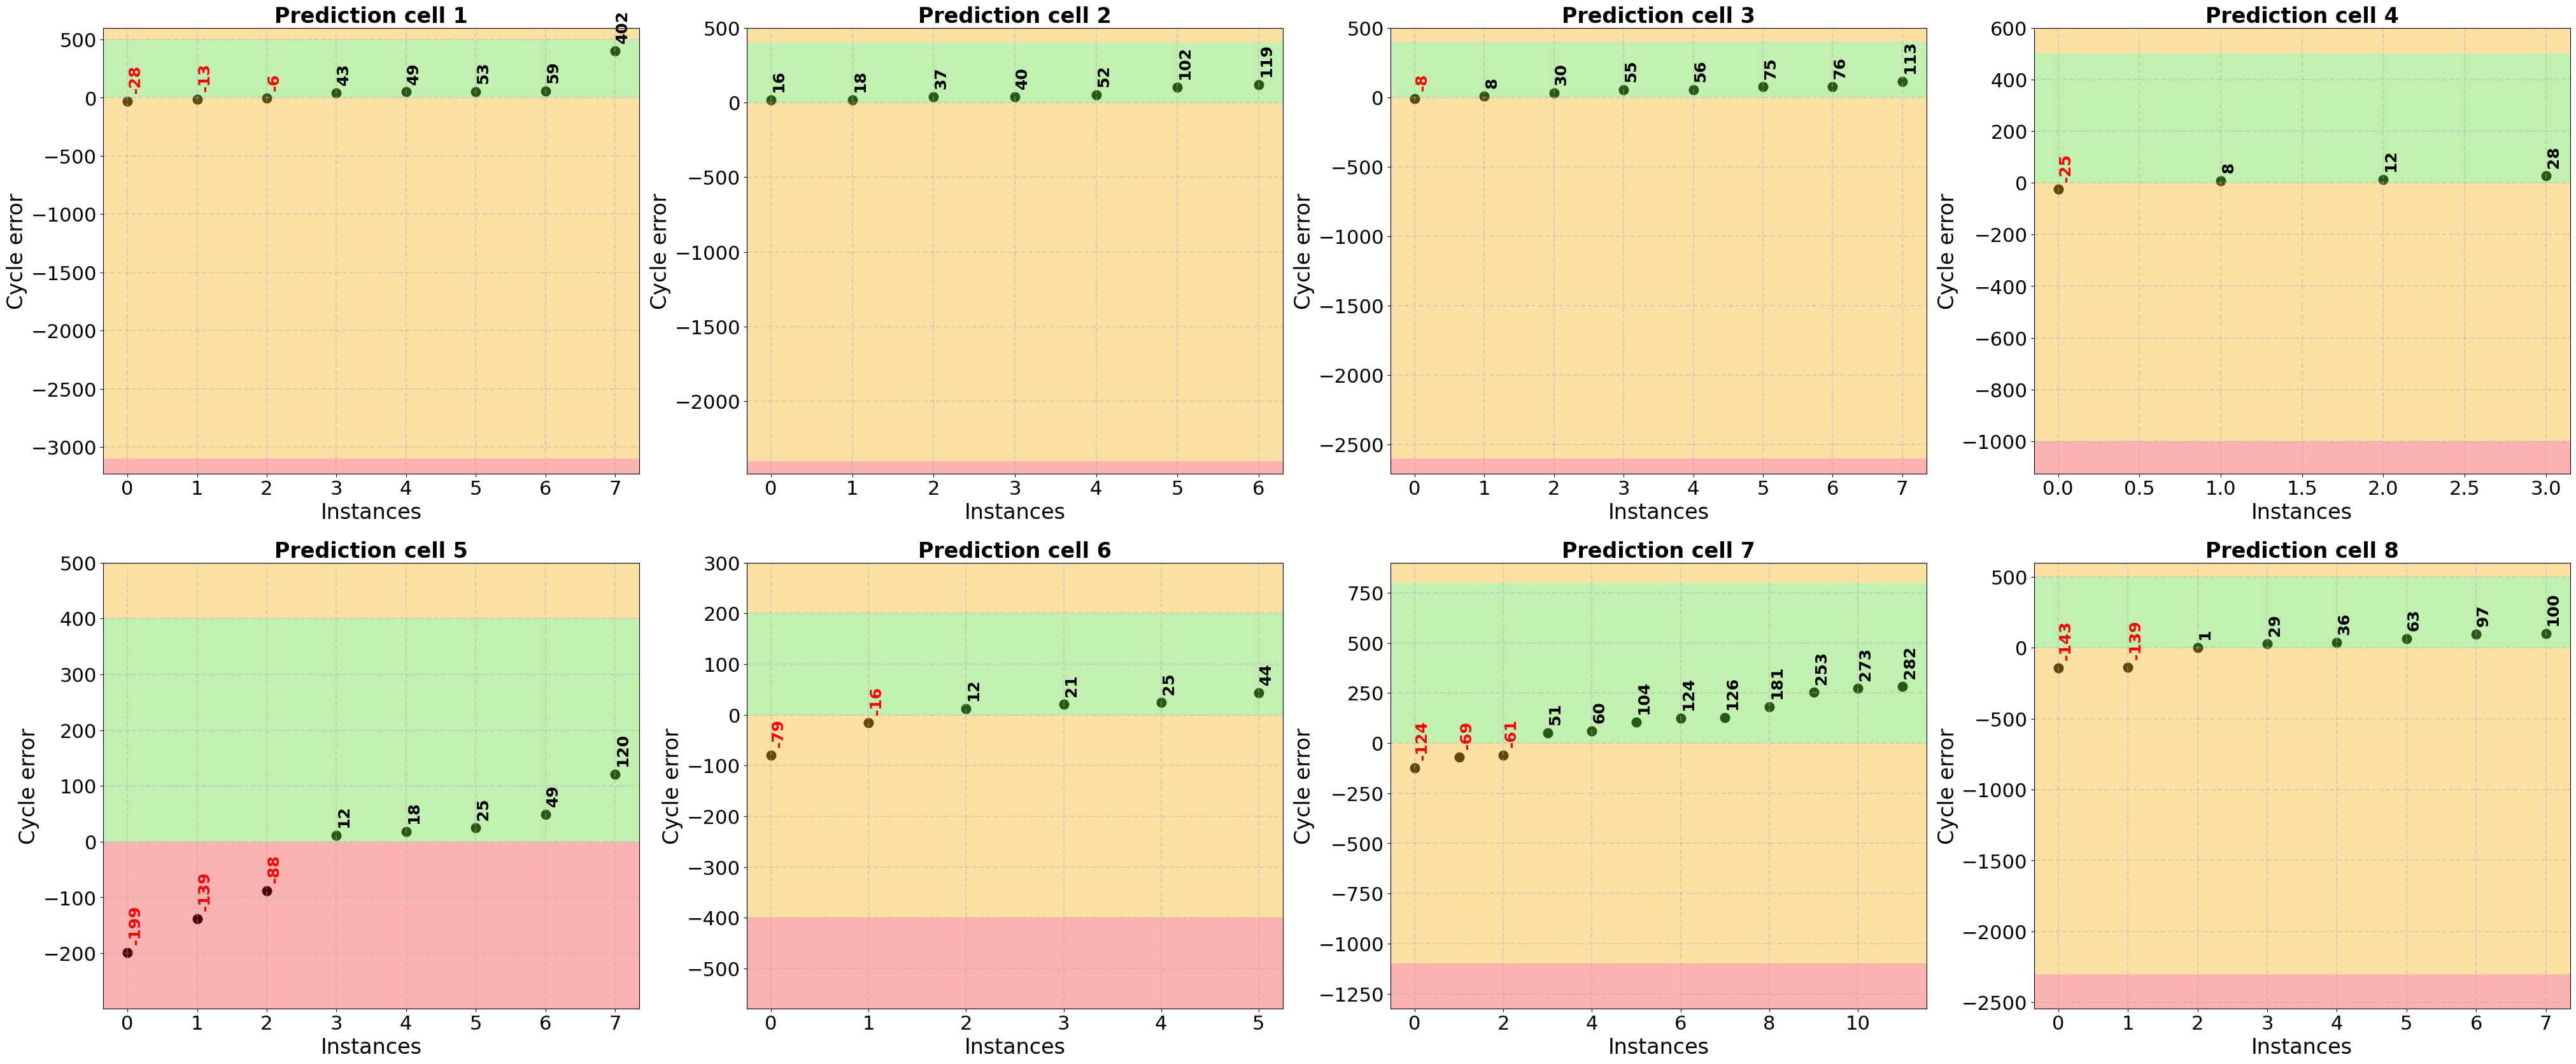

In [15]:
scatter_plot_prediction(ypred_bi_lstm_good_adapted_11, y_test, y_test_mod)

* Train

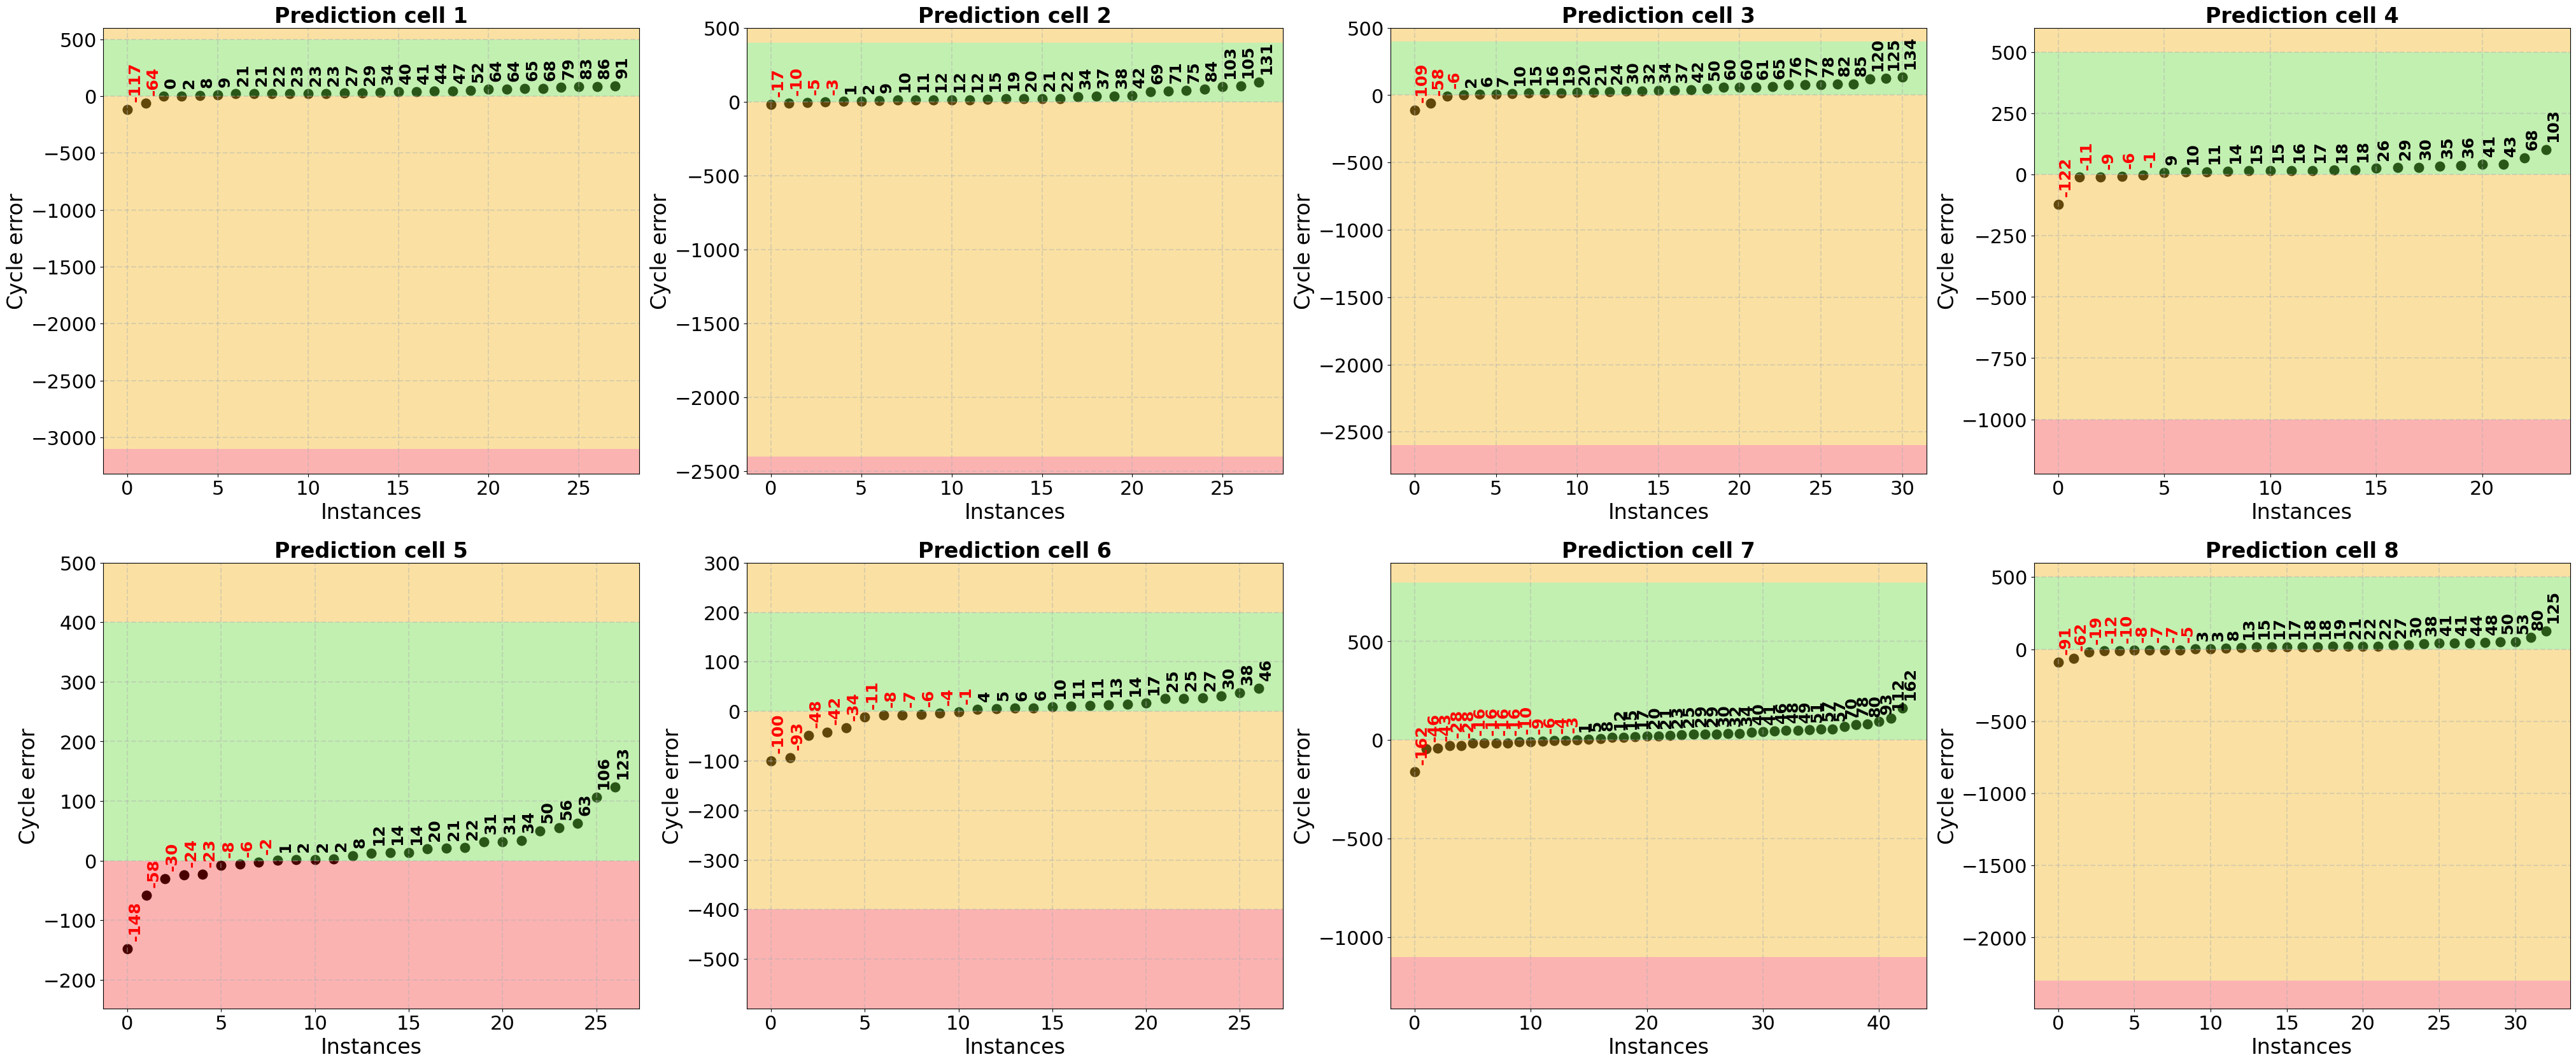

In [36]:
scatter_plot_prediction(ypred_train_bi_lstm_good_adapted, y_train, y_train_mod)

* Test

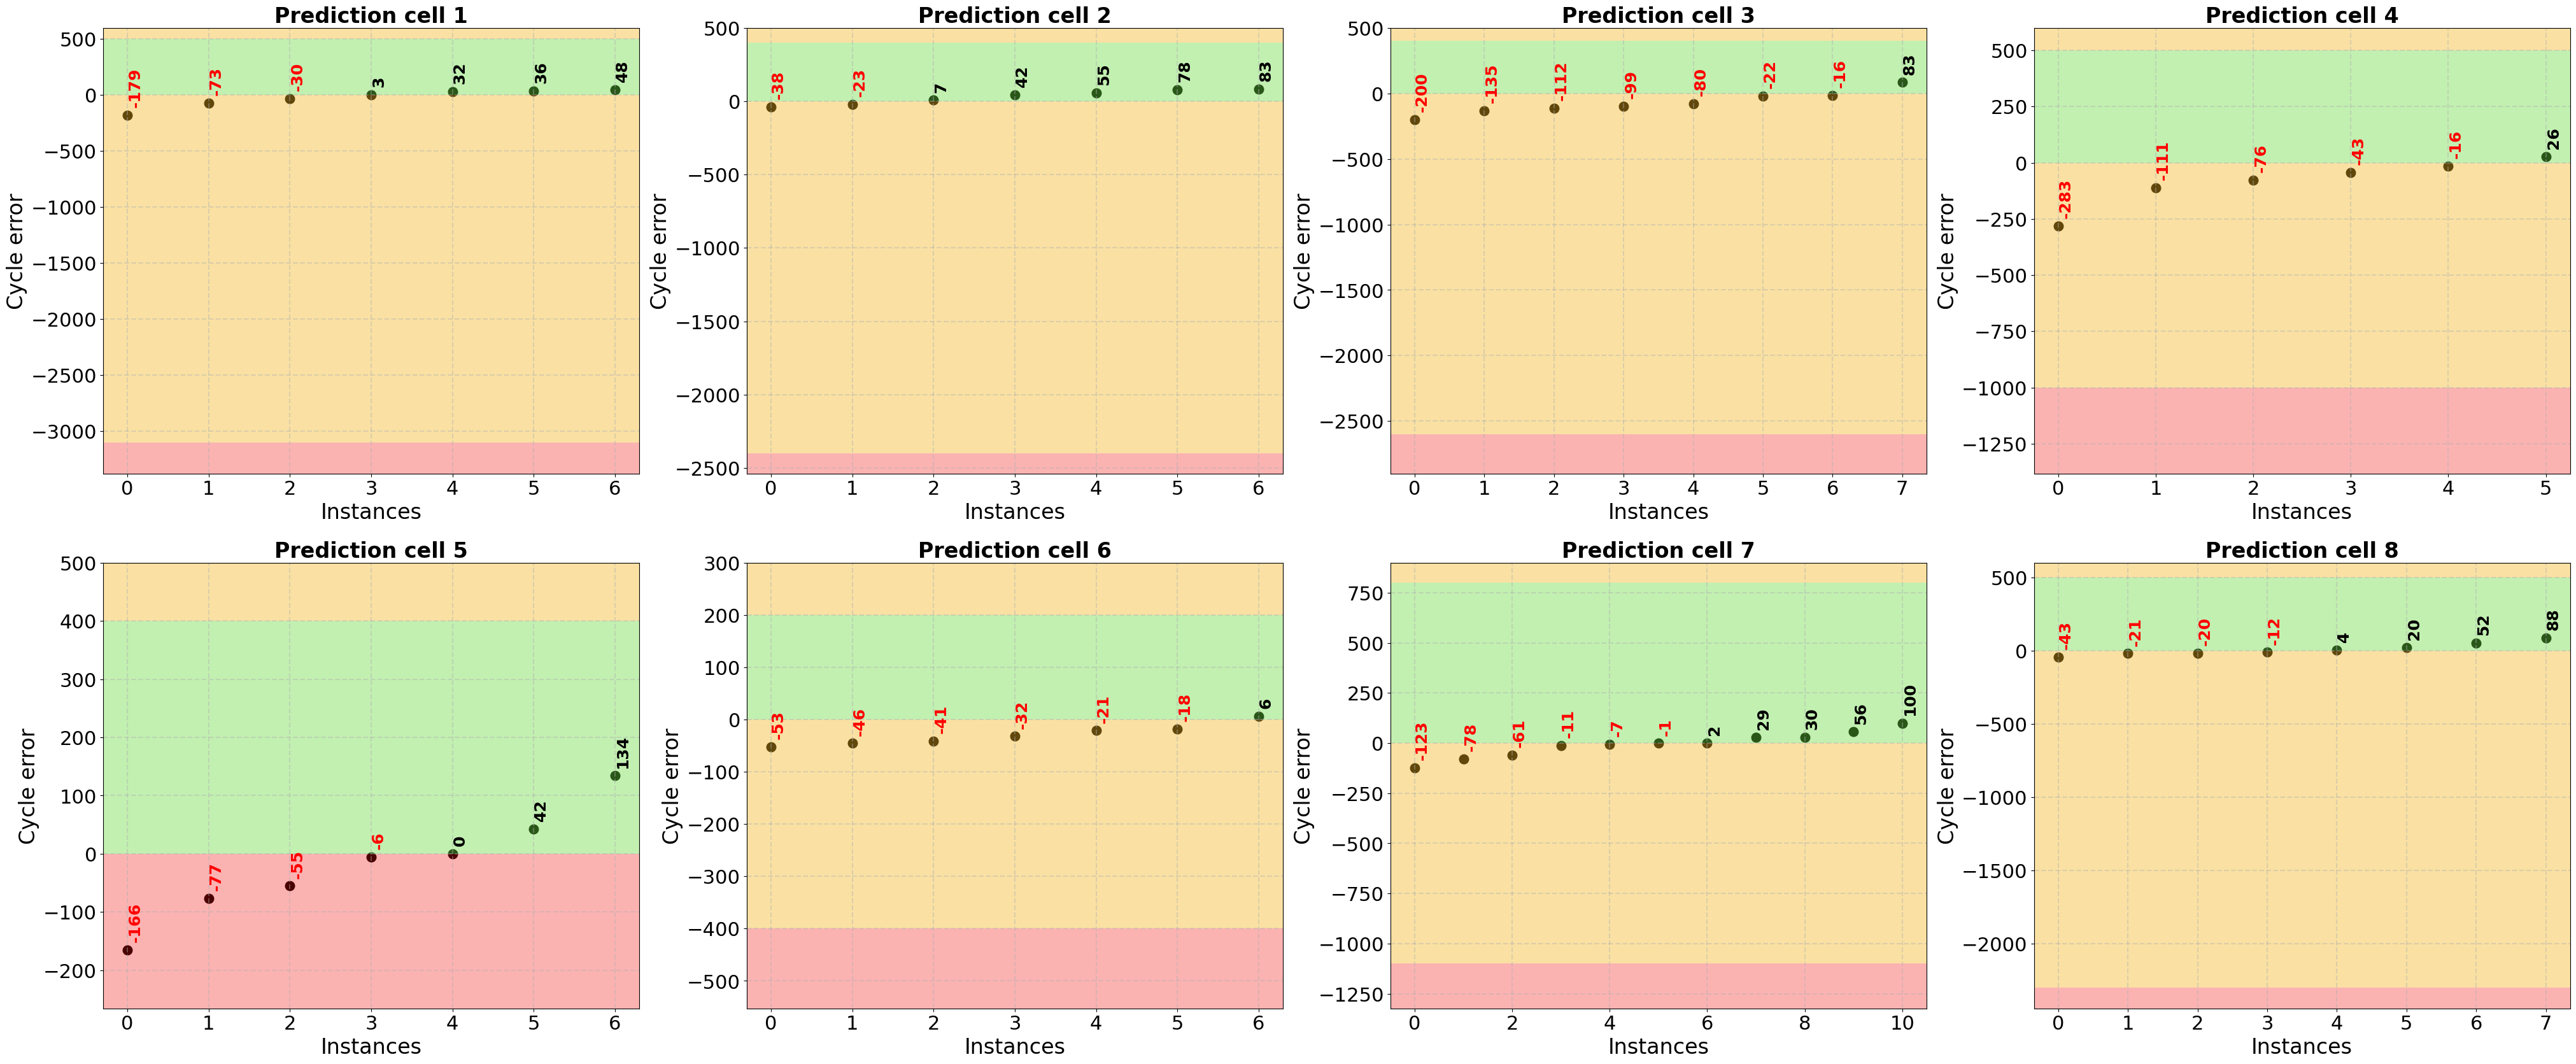

In [42]:
scatter_plot_prediction(ypred_bi_hyperas_lstm24, y_test_false, y_test_mod_false)

* Train

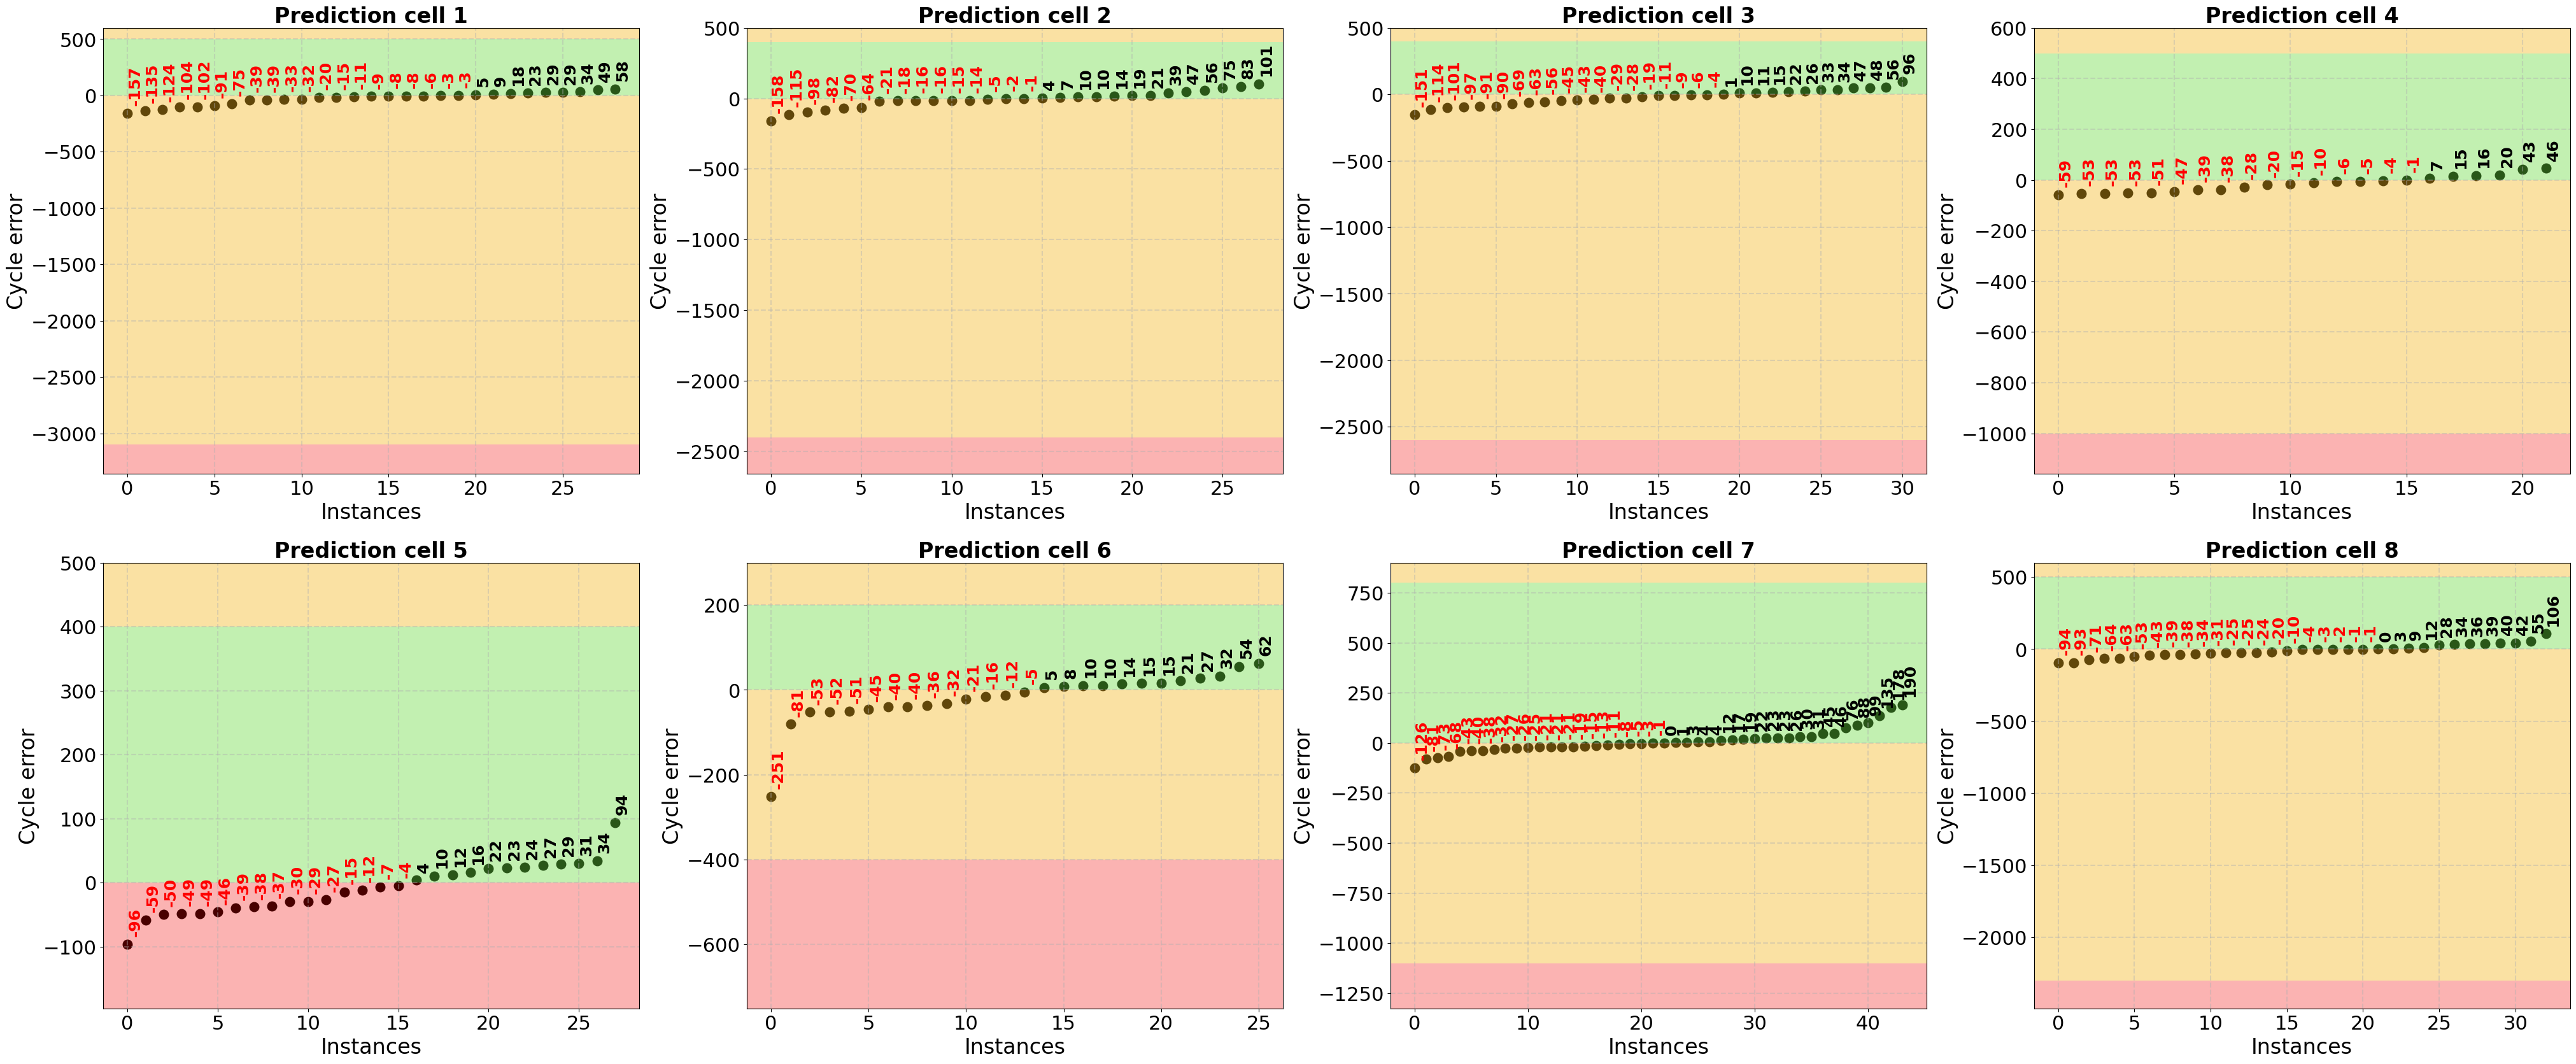

In [45]:
scatter_plot_prediction(ypred_train_bi_hyperas_lstm24, y_train_false, y_train_mod_false)

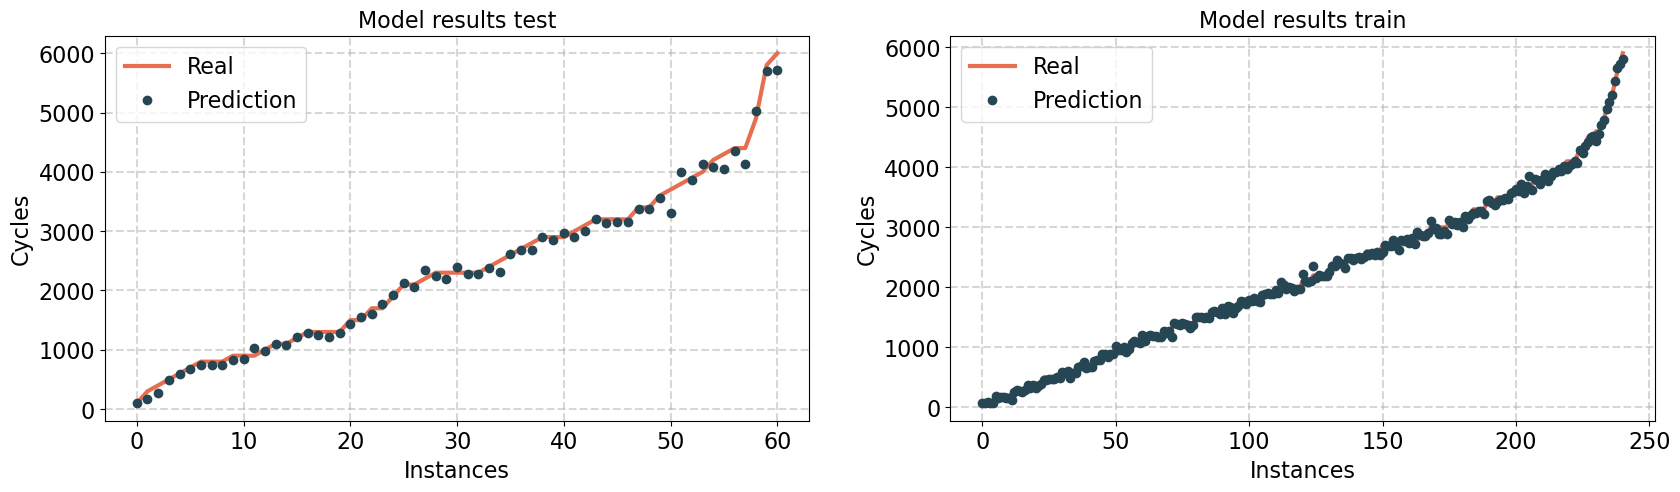

In [61]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
line_plot_result(ypred_bi_lstm_good_adapted, y_test, ' test')
plt.subplot(1, 2, 2)
line_plot_result(ypred_train_bi_lstm_good_adapted, y_train, ' train')

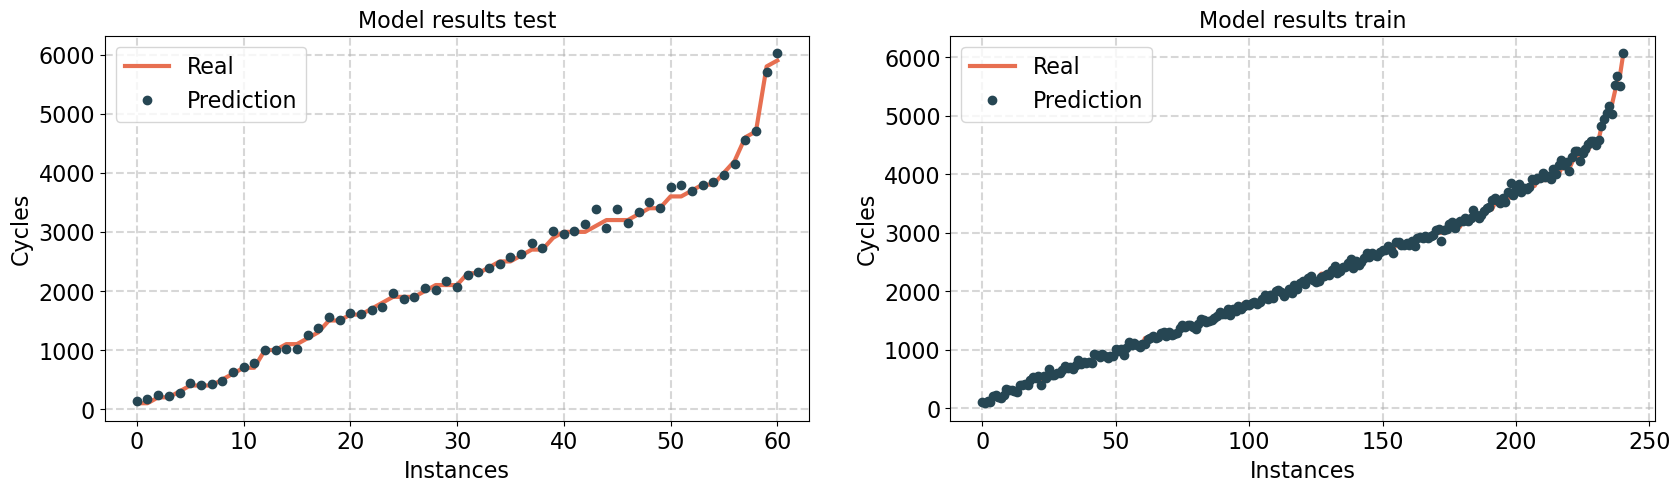

In [60]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
line_plot_result(ypred_bi_hyperas_lstm24, y_test_false, ' test')
plt.subplot(1, 2, 2)
line_plot_result(ypred_train_bi_hyperas_lstm24, y_train_false, ' train')

### Performance of the model for different time steps
---

First, we transform the data to predicti with different time steps

In [ ]:
x_3, y_3 = x_and_y(df_desc_final_pickle, num_steps = 2, index = False)
X_train_3, X_test_3, y_train_3, y_test_3, y_train_mod_3, y_test_mod_3 = stratified_split(x_3, y_3, stratify_2 = True)

x_5, y_5 = x_and_y(df_desc_final_pickle, num_steps = 4, index = False)
X_train_5, X_test_5, y_train_5, y_test_5, y_train_mod_5, y_test_mod_5 = stratified_split(x_5, y_5, stratify_2 = True)

x_7, y_7 = x_and_y(df_desc_final_pickle, num_steps = 6, index = False)
X_train_7, X_test_7, y_train_7, y_test_7, y_train_mod_7, y_test_mod_7 = stratified_split(x_7, y_7, stratify_2 = True)

x_9, y_9 = x_and_y(df_desc_final_pickle, num_steps = 8, index = False)
X_train_9, X_test_9, y_train_9, y_test_9, y_train_mod_9, y_test_mod_9 = stratified_split(x_9, y_9, stratify_2 = True)

(366, 3, 40) (366, 3)
(350, 5, 40) (350, 3)
(334, 7, 40) (334, 3)
(318, 9, 40) (318, 3)


We load the models and predict with the previus sets

In [ ]:
ypred_train_bi_lstm_good_adapted_3, ypred_bi_lstm_good_adapted_3 = return_metric('first_model_Bidirectional_LSTM_good_adapted_3', X_train_3, X_test_3, y_train_3, y_test_3, y_train_mod_3, y_test_mod_3)
ypred_train_bi_lstm_good_adapted_5, ypred_bi_lstm_good_adapted_5 = return_metric('first_model_Bidirectional_LSTM_good_adapted_5', X_train_5, X_test_5, y_train_5, y_test_5, y_train_mod_5, y_test_mod_5)
ypred_train_bi_lstm_good_adapted_7, ypred_bi_lstm_good_adapted_7 = return_metric('first_model_Bidirectional_LSTM_good_adapted_7', X_train_7, X_test_7, y_train_7, y_test_7, y_train_mod_7, y_test_mod_7)
ypred_train_bi_lstm_good_adapted_9, ypred_bi_lstm_good_adapted_9 = return_metric('first_model_Bidirectional_LSTM_good_adapted_9', X_train_9, X_test_9, y_train_9, y_test_9, y_train_mod_9, y_test_mod_9)

10/10 [==============================] - 0s 13ms/step
Train --> 0.9878956520342229 126.73712335873957 171.80318837813553 19011489.01404072
3/3 [==============================] - 0s 10ms/step
Test --> -2.864031239552643 547.5356076214764 3180.3895929275936 12482129823.991995

9/9 [==============================] - 1s 28ms/step
Train --> 0.3293934983755544 1018.7868346078055 1244.9463003995613 4739300896.1474285
3/3 [==============================] - 0s 17ms/step
Test --> 0.36254493502557983 959.5962476457868 1200.0837168164576 4089203877.7559414

9/9 [==============================] - 1s 32ms/step
Train --> 0.996957952677239 61.070232919985884 80.5031271510753 1881184.261688805
3/3 [==============================] - 0s 22ms/step
Test --> 0.9849771455207651 99.04745119009445 179.26831448802426 16154603.291642064

8/8 [==============================] - 1s 49ms/step
Train --> 0.9988640666553203 35.00494736198365 47.79557469499811 306788.9435441264
2/2 [==============================] - 0s 

Considering the previous plots where we divide by colors, we now get the amount of bateries in each color

In [ ]:
green_list_1, yellow_list_1, red_list_1 = green_yellow_red(ypred_bi_lstm_good_adapted_11, y_test, y_test_mod)
green_list_2, yellow_list_2, red_list_2 = green_yellow_red(ypred_bi_lstm_good_adapted_9, y_test_9, y_test_mod_9)
green_list_3, yellow_list_3, red_list_3 = green_yellow_red(ypred_bi_lstm_good_adapted_7, y_test_7, y_test_mod_7)
green_list_4, yellow_list_4, red_list_4 = green_yellow_red(ypred_bi_lstm_good_adapted_5, y_test_5, y_test_mod_5)
green_list_5, yellow_list_5, red_list_5 = green_yellow_red(ypred_bi_lstm_good_adapted_3, y_test_3, y_test_mod_3)

We plot them

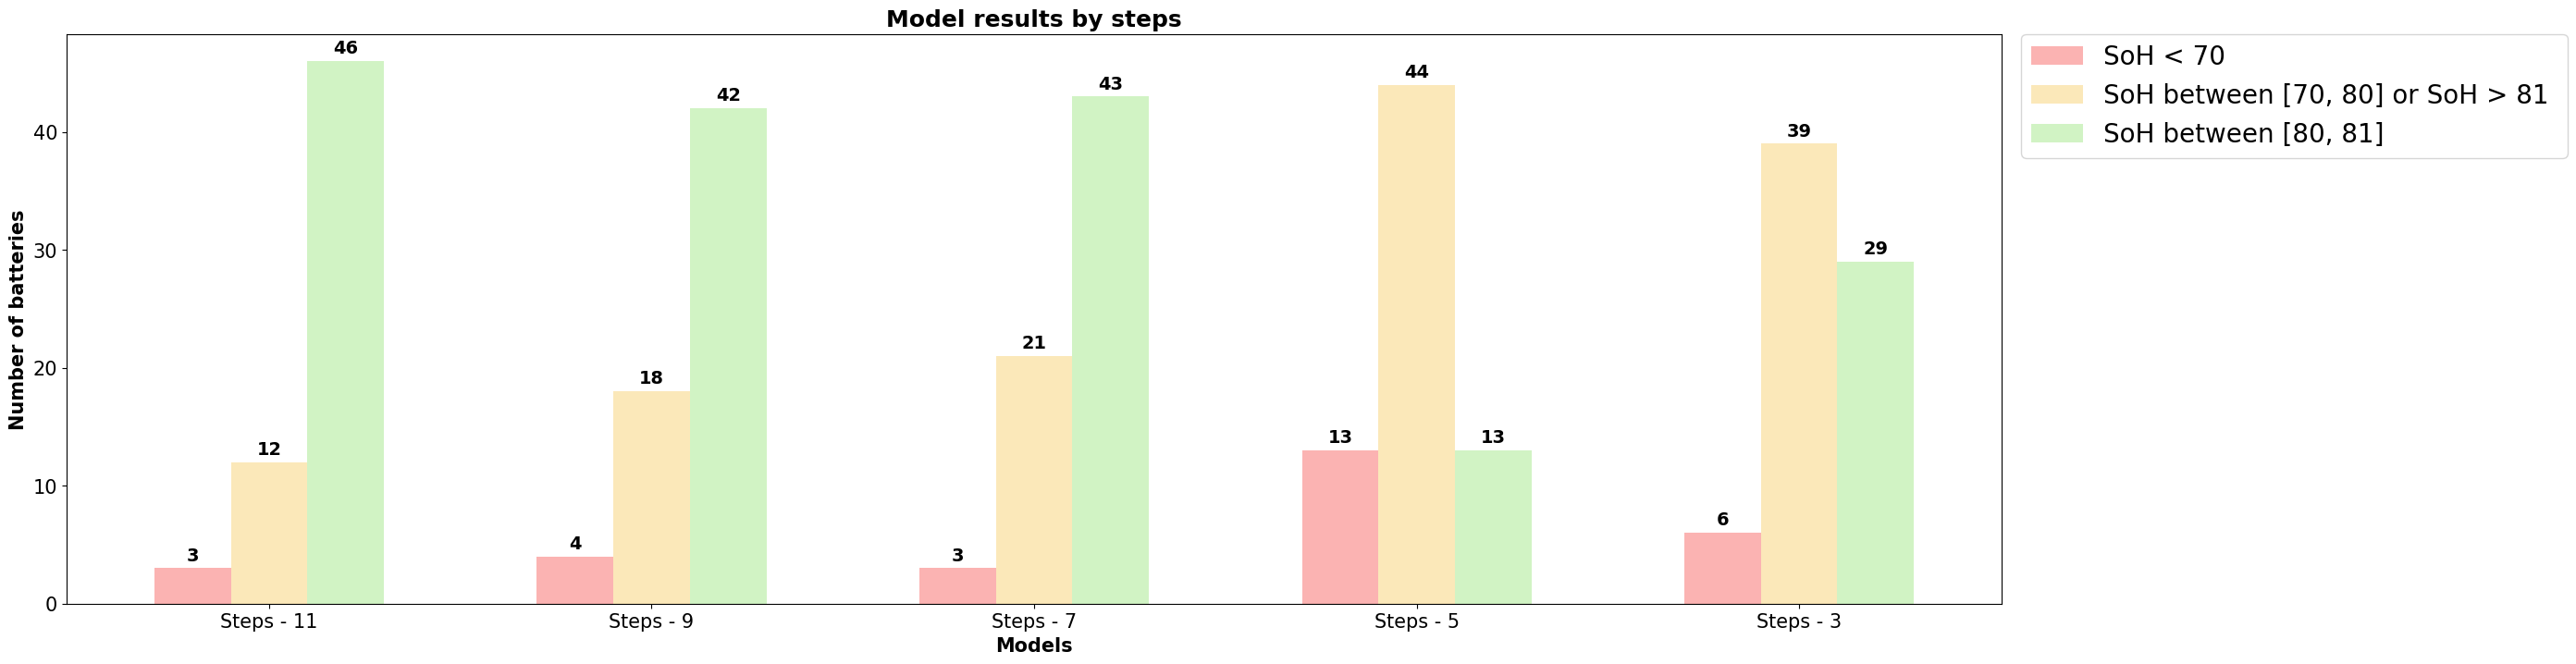

In [92]:
bar_plot_comparison(['Steps - 11', 'Steps - 9', 'Steps - 7', 'Steps - 5', 'Steps - 3'], [red_list_1, red_list_2, red_list_3, red_list_4, red_list_5], \
                                                                                        [yellow_list_1, yellow_list_2, yellow_list_3, yellow_list_4, yellow_list_5], \
                                                                                        [green_list_1, green_list_2, green_list_3, green_list_4, green_list_5])

We calculate the rmse for each model and plot the results.

In [67]:
def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))
list_rmse_test = [rmse(y_test_3, ypred_bi_lstm_good_adapted_3), rmse(y_test_5, ypred_bi_lstm_good_adapted_5), rmse(y_test_7, ypred_bi_lstm_good_adapted_7), \
                                                           rmse(y_test_9, ypred_bi_lstm_good_adapted_9), rmse(y_test, ypred_bi_lstm_good_adapted_11)]

As expected, as the number of steps increases then the results get better

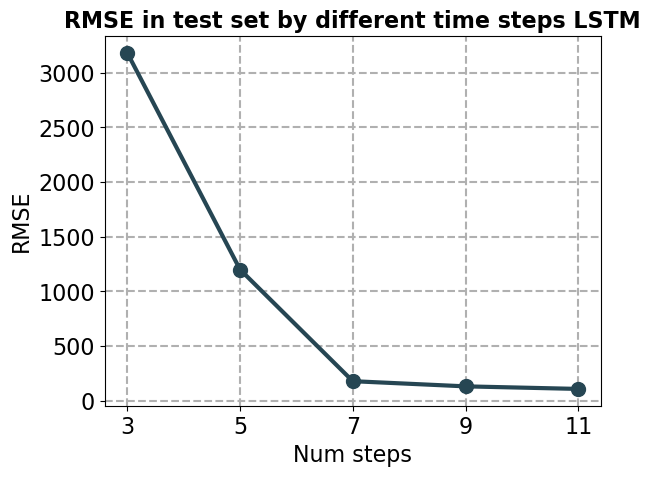

In [79]:
eje_x = ['3', '5', '7', '9', '11']
plt.plot(eje_x, list_rmse_test, color=palette[0], linewidth=3.0)
plt.plot(eje_x, list_rmse_test, 'bo', color=palette[0], markersize=10, label='RMSE Train')
plt.xticks(fontsize=16), plt.yticks(fontsize=16), plt.grid(linestyle='--',linewidth=1.5);
plt.xlabel('Num steps', fontsize = 16), plt.ylabel('RMSE', fontsize = 16),  plt.title(f'RMSE in test set by different time steps LSTM', fontdict=font);